In [3]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.manager import SwarmManager
from backtester.exoinfo import EXOInfo

import pandas as pd
import numpy as np
import scipy

import glob
from pandas.tseries.offsets import *

In [4]:
%pylab inline
%load_ext autoreload
%autoreload 2

figsize(20,10)

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Rng strategies

In [5]:
#
# random time series
#
df = pd.DataFrame()
for i in range(100):
    
    date = pd.date_range(start='2015-01', end='2016-10', freq='D')
    price = np.random.randint(-100, 101, size=len(date))
    
    ser = pd.Series(price, index=date, name='rng_system'+str(i))
    df['rng_system'+str(i)] = ser.cumsum()

## Select input DF. Real swarms or RNG pseudo strategies

In [85]:
# Real swarms
#df = campaign_portfolio

# Rng strategies
#df = df

# Real swarms from csv
#df = pd.read_csv('./swarms_df/ma_cross_swarm_new.csv', parse_dates=[0],
#                dayfirst=True, index_col=0).asfreq(BDay())

# set file name here
swarm_file = 'GCE_CallSpread_SwingPoint_Long_bearish_breakout_Aggresive_Long (Small SPL)'

# Real swarm from .swm
df = SwarmManager.load('./temp_swarms/'+swarm_file+'.swm')
df = df.swarm

FileNotFoundError: [Errno 2] No such file or directory: './temp_swarms/GCE_CallSpread_SwingPoint_Long_bearish_breakout_Aggresive_Long (Small SPL).swm'

In [86]:
df = pd.DataFrame()

for file in glob.glob("./portfolios/*.csv"):
    
    portfolio_df = pd.read_csv(file, dayfirst=True, index_col=[0], parse_dates=[0], names=['date', file.split('\\')[1].split('.')[0]])
    portfolio_df = portfolio_df.groupby(portfolio_df.index).last().asfreq(BDay())
    
    #portfolio_df.columns[0] = file.split('\\')[1].split('.')[0]
    
    if len(df) == 0:
        df = portfolio_df
    else:
        df = pd.concat([df, portfolio_df],axis=1)
        
df = df.ffill().fillna(0.0)


In [87]:
df

,CLE_BullishCollar_PointAndFigurePatterns_Short,CLE_BullishCollar_RenkoPatterns_no_exit_on_patterns_Short,EU6_BearishCollarBrokenWing_IchimokuCloud_Long,GCE_CallSpread_MACross_Long_MA_Cross_Long,GCE_CallSpread_MACross_Short_MA_Cross_Short,GCE_CallSpread_SwingPoint_Long_bearish_breakout_Aggresive_Long (Small SPL),GCE_CallSpread_SwingPoint_Long_bearish_breakout_Conservative_Long (large SPh),GCE_CallSpread_SwingPoint_Long_bearish_failure_Aggresive_Long (Small SPL),ZCE_PutSpread_SwingPoint_Short_bullishfailue Conservative_Short (Small SPL )
date,,,,,,,,,
2011-01-10,0.0,0.0,0.00,0.0,0.0,0.000000e+00,0.0,0.0,0.00
2011-01-11,0.0,0.0,0.00,0.0,0.0,0.000000e+00,0.0,0.0,0.00
2011-01-12,0.0,0.0,0.00,0.0,0.0,0.000000e+00,0.0,0.0,0.00
2011-01-13,0.0,0.0,0.00,0.0,0.0,0.000000e+00,0.0,0.0,0.00
2011-01-14,0.0,0.0,0.00,0.0,0.0,0.000000e+00,0.0,0.0,0.00
2011-01-17,-18.0,0.0,0.00,0.0,0.0,-8.000000e+01,0.0,0.0,0.00
2011-01-18,-438.0,0.0,0.00,0.0,0.0,1.600000e+02,0.0,0.0,0.00
2011-01-19,-288.0,0.0,0.00,0.0,0.0,-1.000000e+02,0.0,0.0,0.00
2011-01-20,402.0,0.0,0.00,0.0,0.0,-1.900000e+02,0.0,0.0,0.00


In [88]:
swarm = SwarmManager.load('./temp_swarms/'+swarm_file+'.swm')

FileNotFoundError: [Errno 2] No such file or directory: './temp_swarms/GCE_CallSpread_SwingPoint_Long_bearish_breakout_Aggresive_Long (Small SPL).swm'

## Systems overall performance estimation

In [89]:
temp_l = []

for strat in df.columns:

        input_strategy_data = df[strat] # This data is used in metrics calc

        price_change = input_strategy_data.diff()
        max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
        netprofit = df[strat].ix[-1] - df[strat].ix[0]

        # Since swarm PnL statistics is not trade-by-trade
        # For PF calc I used cumulative values of positive and negatives price changes
        # Same for winrate
        profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

        winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

        try:
            modsharpe = np.mean(price_change) / np.std(price_change)

        except ZeroDivisionError:
            modsharpe = np.nan

        d = {'strategy': strat,
            'stats_pricechange_modsharpe': modsharpe, 
            'stats_netprofit': netprofit,
            'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
            'stats_profit_factor': profit_factor, 'stats_winrate': winrate }

        temp_l.append(d)

In [90]:
strategies_performance_df = pd.DataFrame(temp_l).dropna()
strategies_performance_df['rank_score'] = np.zeros_like(len(strategies_performance_df))
strategies_performance_df

,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
0,-5910.00,30378.00,0.073598,1.500940,5.140102,15.347222,CLE_BullishCollar_PointAndFigurePatterns_Short,0
1,-9360.00,27976.00,0.053409,1.286581,2.988889,18.680556,CLE_BullishCollar_RenkoPatterns_no_exit_on_pat...,0
2,-42620.25,-6401.00,-0.006690,0.963618,-0.150187,12.361111,EU6_BearishCollarBrokenWing_IchimokuCloud_Long,0
3,-4024.00,18012.00,0.061727,2.057539,4.476143,3.888889,GCE_CallSpread_MACross_Long_MA_Cross_Long,0
4,-7416.00,18566.00,0.035530,1.219586,2.503506,18.263889,GCE_CallSpread_MACross_Short_MA_Cross_Short,0
5,-29752.00,22854.00,0.029356,1.134541,0.768150,28.055556,GCE_CallSpread_SwingPoint_Long_bearish_breakou...,0
6,-15838.00,14614.00,0.023911,1.137704,0.922718,16.527778,GCE_CallSpread_SwingPoint_Long_bearish_breakou...,0
7,-8552.00,11692.00,0.026961,1.157706,1.367166,16.736111,GCE_CallSpread_SwingPoint_Long_bearish_failure...,0
8,-3218.50,8213.25,0.044760,1.422835,2.551888,10.625000,ZCE_PutSpread_SwingPoint_Short_bullishfailue C...,0


## Strategies overall performance ranking

In [91]:
ranks_d = {}

for col in strategies_performance_df.columns:
    
    stats_col_flag = False
    
    if 'stats' in col:

        # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
        metric_quantile0 = strategies_performance_df[col].quantile(0.0)
        metric_quantile10 = strategies_performance_df[col].quantile(0.1)
        metric_quantile20 = strategies_performance_df[col].quantile(0.2)
        metric_quantile30 = strategies_performance_df[col].quantile(0.3)
        metric_quantile40 = strategies_performance_df[col].quantile(0.4)
        metric_quantile50 = strategies_performance_df[col].quantile(0.5)
        metric_quantile60 = strategies_performance_df[col].quantile(0.6)
        metric_quantile70 = strategies_performance_df[col].quantile(0.7)
        metric_quantile80 = strategies_performance_df[col].quantile(0.8)
        metric_quantile90 = strategies_performance_df[col].quantile(0.9)
        metric_quantile100 = strategies_performance_df[col].quantile(1)
        
        stats_col_flag = True
    
    if stats_col_flag == True:
        
        for strat in strategies_performance_df.strategy:
        
            # Define strategy statistics rank of certain strategy

            strategy_stats_metric = strategies_performance_df[strategies_performance_df.strategy == strat][col].values[0]

            if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                rank_score = 0

            elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                rank_score = 1

            elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                rank_score = 2

            elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                rank_score = 3

            elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                rank_score = 4

            elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                rank_score = 5

            elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                rank_score = 6

            elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                rank_score = 7

            elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                rank_score = 8

            elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                rank_score = 9

            elif strategy_stats_metric == metric_quantile100:
                rank_score = 10

                
            if strat not in ranks_d.keys():               
                ranks_d[strat] = rank_score
                
            elif strat in ranks_d.keys():                
                ranks_d[strat] = ranks_d[strat] + rank_score
                          
            # For debugging purposes

            #print('strategy---',strat,'\n')
            #print(col)
            #print('10 quantile---',metric_quantile10)
            #print(strategy_stats_metric)
            #print('60 quantile---',metric_quantile60)
            #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
            #print('rank_score------', rank_score, '\n')

        #print("NEXT----------------------- \n")

# Set rank scores for strategies from dict

for k in ranks_d:
    
    strat_index = strategies_performance_df[strategies_performance_df.strategy == k].index
    strategies_performance_df = strategies_performance_df.set_value(strat_index, 'rank_score', ranks_d[k])

In [78]:
strategies_performance_df.sort_values('rank_score', ascending=False)

,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
0,-5910.00,30378.00,0.073598,1.500940,5.140102,15.347222,CLE_BullishCollar_PointAndFigurePatterns_Short,45
1,-9360.00,27976.00,0.053409,1.286581,2.988889,18.680556,CLE_BullishCollar_RenkoPatterns_no_exit_on_pat...,39
3,-4024.00,18012.00,0.061727,2.057539,4.476143,3.888889,GCE_CallSpread_MACross_Long_MA_Cross_Long,37
4,-7416.00,18566.00,0.035530,1.219586,2.503506,18.263889,GCE_CallSpread_MACross_Short_MA_Cross_Short,31
8,-3218.50,8213.25,0.044760,1.422835,2.551888,10.625000,ZCE_PutSpread_SwingPoint_Short_bullishfailue C...,30
5,-29752.00,22854.00,0.029356,1.134541,0.768150,28.055556,GCE_CallSpread_SwingPoint_Long_bearish_breakou...,22
7,-8552.00,11692.00,0.026961,1.157706,1.367166,16.736111,GCE_CallSpread_SwingPoint_Long_bearish_failure...,20
6,-15838.00,14614.00,0.023911,1.137704,0.922718,16.527778,GCE_CallSpread_SwingPoint_Long_bearish_breakou...,14
2,-42620.25,-6401.00,-0.006690,0.963618,-0.150187,12.361111,EU6_BearishCollarBrokenWing_IchimokuCloud_Long,2


## Drop all strategies which have rank score less than n quantile value 

In [10]:
df = df[strategies_performance_df[strategies_performance_df.rank_score >= strategies_performance_df.rank_score.quantile(0.5)].strategy]

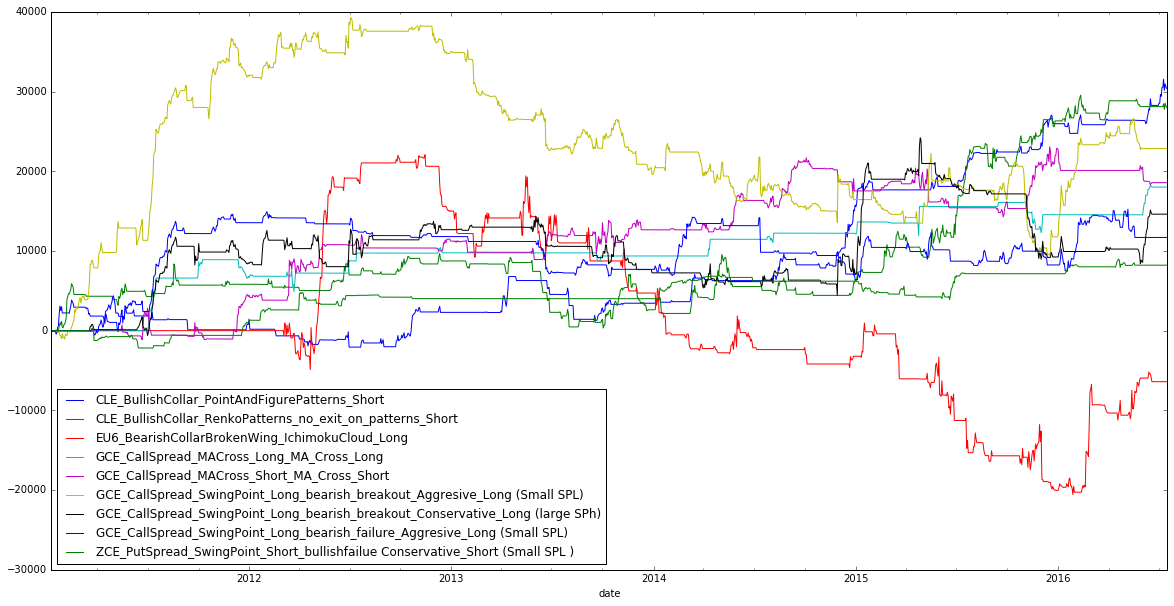

In [79]:
df.dropna().plot()

## Filter those strategies by correlation

In [80]:
# Rearrange columns from best to worst strategies
df = df.reindex_axis(strategies_performance_df.sort_values('rank_score', ascending=False).strategy, axis=1).dropna(axis=1).asfreq(BDay())

In [81]:
df.corr()

strategy,CLE_BullishCollar_PointAndFigurePatterns_Short,CLE_BullishCollar_RenkoPatterns_no_exit_on_patterns_Short,GCE_CallSpread_MACross_Long_MA_Cross_Long,GCE_CallSpread_MACross_Short_MA_Cross_Short,ZCE_PutSpread_SwingPoint_Short_bullishfailue Conservative_Short (Small SPL ),GCE_CallSpread_SwingPoint_Long_bearish_breakout_Aggresive_Long (Small SPL),GCE_CallSpread_SwingPoint_Long_bearish_failure_Aggresive_Long (Small SPL),GCE_CallSpread_SwingPoint_Long_bearish_breakout_Conservative_Long (large SPh),EU6_BearishCollarBrokenWing_IchimokuCloud_Long
strategy,,,,,,,,,
CLE_BullishCollar_PointAndFigurePatterns_Short,1.000000,0.871312,0.758476,0.719525,0.690057,-0.407661,0.063906,0.453060,-0.735105
CLE_BullishCollar_RenkoPatterns_no_exit_on_patterns_Short,0.871312,1.000000,0.647087,0.533076,0.600717,-0.093321,0.228208,0.389359,-0.590728
GCE_CallSpread_MACross_Long_MA_Cross_Long,0.758476,0.647087,1.000000,0.845030,0.836491,0.048372,0.486598,0.727851,-0.400531
GCE_CallSpread_MACross_Short_MA_Cross_Short,0.719525,0.533076,0.845030,1.000000,0.922028,-0.177425,0.267704,0.438513,-0.358260
ZCE_PutSpread_SwingPoint_Short_bullishfailue Conservative_Short (Small SPL ),0.690057,0.600717,0.836491,0.922028,1.000000,-0.062878,0.364546,0.401975,-0.349734
GCE_CallSpread_SwingPoint_Long_bearish_breakout_Aggresive_Long (Small SPL),-0.407661,-0.093321,0.048372,-0.177425,-0.062878,1.000000,0.715333,0.283246,0.577058
GCE_CallSpread_SwingPoint_Long_bearish_failure_Aggresive_Long (Small SPL),0.063906,0.228208,0.486598,0.267704,0.364546,0.715333,1.000000,0.457721,0.087839
GCE_CallSpread_SwingPoint_Long_bearish_breakout_Conservative_Long (large SPh),0.453060,0.389359,0.727851,0.438513,0.401975,0.283246,0.457721,1.000000,-0.087005
EU6_BearishCollarBrokenWing_IchimokuCloud_Long,-0.735105,-0.590728,-0.400531,-0.358260,-0.349734,0.577058,0.087839,-0.087005,1.000000


In [82]:
corr_df = df.corr()

while_loop_break_flag = False

while True:   
    if while_loop_break_flag == False:
        
        for i in range(len(corr_df)):

            try:       
                strat_corr = corr_df[corr_df.columns[i]]
            
            except IndexError:               
                strat_corr = corr_df[corr_df.columns[-1]]
            
            df = df.drop(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.5)].index, axis=1)

            # Check if previous DF are the same as current DF
            # If they are different - continue the loop

            df_comparison_array = np.array_equal(corr_df,df.corr())
            
            #print(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.5)].index)
            #print(i)
            #print(len(corr_df))
            #print(len(corr_df))
            
            if df_comparison_array  == False and i < len(corr_df):
                corr_df = df.corr()

            elif df_comparison_array  == True and i == len(corr_df)-1:
                while_loop_break_flag = True
                break
                    
    if while_loop_break_flag == True:
        break

In [83]:
df.corr()

strategy,CLE_BullishCollar_PointAndFigurePatterns_Short,GCE_CallSpread_SwingPoint_Long_bearish_breakout_Aggresive_Long (Small SPL),GCE_CallSpread_SwingPoint_Long_bearish_breakout_Conservative_Long (large SPh)
strategy,,,
CLE_BullishCollar_PointAndFigurePatterns_Short,1.000000,-0.407661,0.453060
GCE_CallSpread_SwingPoint_Long_bearish_breakout_Aggresive_Long (Small SPL),-0.407661,1.000000,0.283246
GCE_CallSpread_SwingPoint_Long_bearish_breakout_Conservative_Long (large SPh),0.453060,0.283246,1.000000


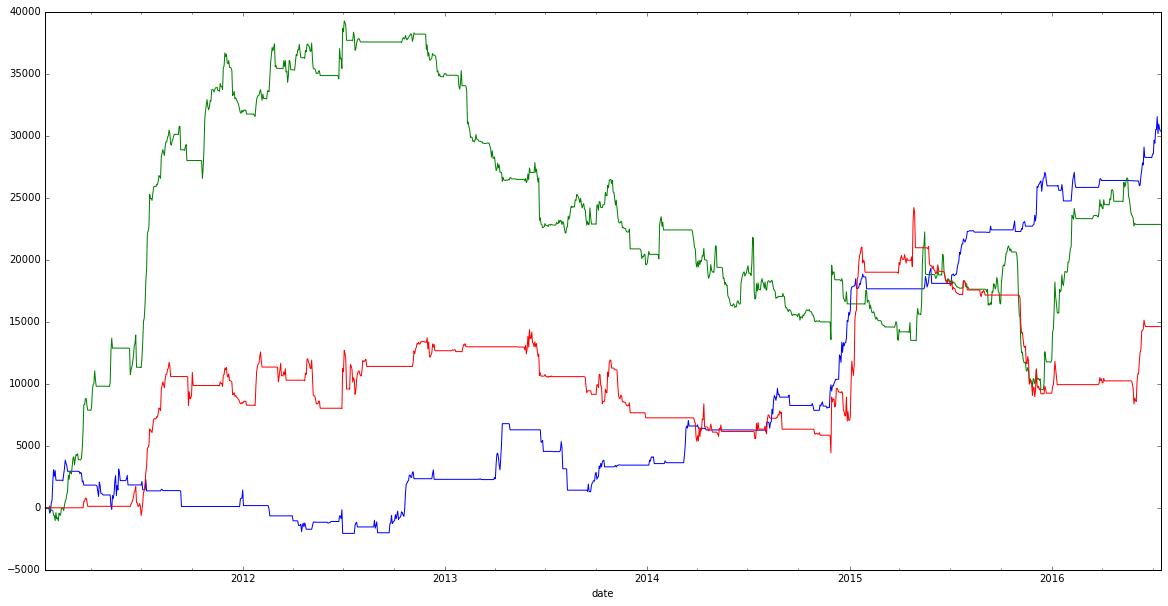

In [84]:
df.dropna().plot(legend=False)

# Metrics calculation

In [92]:
#
# Rebalance triggers
#
# Rebalance trigger must be array of Datetime indexes when event occurred, like date of monday or new month
# 
newmonth = df[df.index.month != df.index.shift(1).month].index

monday = df[df.index.weekday == 0].index

norebalance = [df.index[-1]]

newyear = df[df.index.year != df.index.shift(1).year].index
#
#
#

# note: I think more performance metrics for strategies is better
# https://www.amibroker.com/guide/h_report.html for reference

rebalance_index = 1
rebalance_date_start = None

rebalance_trigger = monday # set rebalance trigger here

temp_l = []

for reb_idx in rebalance_trigger:
    
    for strat in df.columns:

        if rebalance_index == 1:
            rebalance_date_start = df.index[0]
           
        for i in range(len(df[strat])):

            if df[strat].index[i] == reb_idx:

                input_strategy_data = df[strat].ix[rebalance_date_start:reb_idx] # This data is used in metrics calc
                
                price_change = input_strategy_data.diff()
                max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
                netprofit = df[strat].ix[reb_idx] - df[strat].ix[rebalance_date_start]
                
                # Since swarm PnL statistics is not trade-by-trade
                # For PF calc I used cumulative values of positive and negatives price changes
                # Same for winrate
                profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())
                
                winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               
                # If all trades are negative, PF is 0. But later all 0s is replaced with NaN. 
                # To avoid replacing true 0.0 PF set it to 0.000001
                # This made for handling missing data 
                
                # Also winrate can be 0.0, but if PF is NaN - no trades were made
                # This made for handling missing data 
                
                if winrate == 0.0 and np.isnan(profit_factor) == False:
                    winrate = 0.000001
                
                elif winrate == 0.0 and np.isnan(profit_factor) == True:
                    winrate = np.nan
                                
                if profit_factor == 0.0:
                    profit_factor = 0.000001                
                          
                try:
                    modsharpe = np.mean(price_change) / np.std(price_change)
                    
                except ZeroDivisionError:
                    modsharpe = np.nan
            
                
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_netprofit': netprofit,
                    'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
                    'stats_profit_factor': profit_factor, 'stats_winrate': winrate }
                
                '''
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_recovery_factor': netprofit / np.abs(max_dd)}
                '''
                
                temp_l.append(d)
    
    rebalance_index += 1
    rebalance_date_start = reb_idx # set new start rebalance date to current rebalance trigger date

### Data cleaning

In [93]:
# Replacing 0 values with NaNs
# If strategy stats is 0 means that no trades were made
stats_df = pd.DataFrame(temp_l).replace(0, np.nan)

# Filling NaNs with last avaible values
for s in stats_df.strategy.unique():
    stats_df[stats_df.strategy == s] = stats_df[stats_df.strategy == s].fillna(method='pad')

stats_df = stats_df.dropna(how='any')

In [94]:
stats_df

,rebalance_date_end,rebalance_date_start,rebalance_index,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy
9,2011-01-17,2011-01-10,2,-18.00,-18.00,-0.500000,1.000000e-06,-1.000000,0.000001,CLE_BullishCollar_PointAndFigurePatterns_Short
14,2011-01-17,2011-01-10,2,-80.00,-80.00,-0.500000,1.000000e-06,-1.000000,0.000001,GCE_CallSpread_SwingPoint_Long_bearish_breakou...
18,2011-01-24,2011-01-17,3,-420.00,2120.00,0.659589,6.047619e+00,5.047619,80.000000,CLE_BullishCollar_PointAndFigurePatterns_Short
23,2011-01-24,2011-01-17,3,-390.00,-150.00,-0.186339,6.153846e-01,-0.384615,20.000000,GCE_CallSpread_SwingPoint_Long_bearish_breakou...
27,2011-01-31,2011-01-24,4,-860.00,120.00,0.037308,1.090909e+00,0.139535,40.000000,CLE_BullishCollar_PointAndFigurePatterns_Short
28,2011-01-31,2011-01-24,4,-798.00,-118.00,-0.049631,8.895131e-01,-0.147870,40.000000,CLE_BullishCollar_RenkoPatterns_no_exit_on_pat...
32,2011-01-31,2011-01-24,4,-800.00,-660.00,-0.312400,4.923077e-01,-0.825000,20.000000,GCE_CallSpread_SwingPoint_Long_bearish_breakou...
36,2011-02-07,2011-01-31,5,-860.00,120.00,0.037308,1.090909e+00,0.139535,40.000000,CLE_BullishCollar_PointAndFigurePatterns_Short
37,2011-02-07,2011-01-31,5,-798.00,3590.00,0.845317,inf,inf,100.000000,CLE_BullishCollar_RenkoPatterns_no_exit_on_pat...
41,2011-02-07,2011-01-31,5,-260.00,290.00,0.190542,1.690476e+00,1.115385,40.000000,GCE_CallSpread_SwingPoint_Long_bearish_breakou...


## Statistics rank calculation

In [95]:
ranks_d = {}
ranks_rebidx_d = {}

for i in stats_df.rebalance_index.unique():

    for col in stats_df[stats_df.rebalance_index == i].columns:
        
        stats_col_flag = False
    
        if 'stats' in col:

            # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
            metric_quantile0 = stats_df[col].quantile(0.0)
            metric_quantile10 = stats_df[col].quantile(0.1)
            metric_quantile20 = stats_df[col].quantile(0.2)
            metric_quantile30 = stats_df[col].quantile(0.3)
            metric_quantile40 = stats_df[col].quantile(0.4)
            metric_quantile50 = stats_df[col].quantile(0.5)
            metric_quantile60 = stats_df[col].quantile(0.6)
            metric_quantile70 = stats_df[col].quantile(0.7)
            metric_quantile80 = stats_df[col].quantile(0.8)
            metric_quantile90 = stats_df[col].quantile(0.9)
            metric_quantile100 = stats_df[col].quantile(1)

            stats_col_flag = True

        if stats_col_flag == True:
    
            for strat in stats_df[stats_df.rebalance_index == i].strategy:

                # Define strategy statistics rank of certain strategy

                strategy_stats_metric = stats_df[(stats_df.rebalance_index == i) 
                                                 & (stats_df.strategy == strat)][col].values[0]

                if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                    rank_score = 0

                elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                    rank_score = 1

                elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                    rank_score = 2

                elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                    rank_score = 3

                elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                    rank_score = 4

                elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                    rank_score = 5

                elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                    rank_score = 6

                elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                    rank_score = 7

                elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                    rank_score = 8

                elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                    rank_score = 9

                elif strategy_stats_metric == metric_quantile100:
                    rank_score = 10

                    
                if strat not in ranks_d.keys():               
                    ranks_d[strat] = rank_score
                    
                elif strat in ranks_d.keys():                
                    ranks_d[strat] = ranks_d[strat] + rank_score
            #ranks_d['rebalance_idx_'+str(i)] = i

                    
                # For debugging purposes

                #print('strategy---',strat,'\n')
                #print(col)
                #print('10 quantile---',metric_quantile10)
                #print(strategy_stats_metric)
                #print('60 quantile---',metric_quantile60)
                #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
                #print('rank_score------', rank_score, '\n')

    
    print('rebalance index ---', i)
    #break
    for k in ranks_d:

        strat_index = stats_df[(stats_df.strategy == k) & ((stats_df.rebalance_index == i))].index
        #print(strat_index)
        stats_df = stats_df.set_value(strat_index, 'rank_score', ranks_d[k])
        
    ranks_d = {}

rebalance index --- 2
rebalance index --- 3
rebalance index --- 4
rebalance index --- 5
rebalance index --- 6
rebalance index --- 7
rebalance index --- 8
rebalance index --- 9
rebalance index --- 10
rebalance index --- 11
rebalance index --- 12
rebalance index --- 13
rebalance index --- 14
rebalance index --- 15
rebalance index --- 16
rebalance index --- 17
rebalance index --- 18
rebalance index --- 19
rebalance index --- 20
rebalance index --- 21
rebalance index --- 22
rebalance index --- 23
rebalance index --- 24
rebalance index --- 25
rebalance index --- 26
rebalance index --- 27
rebalance index --- 28
rebalance index --- 29
rebalance index --- 30
rebalance index --- 31
rebalance index --- 32
rebalance index --- 33
rebalance index --- 34
rebalance index --- 35
rebalance index --- 36
rebalance index --- 37
rebalance index --- 38
rebalance index --- 39
rebalance index --- 40
rebalance index --- 41
rebalance index --- 42
rebalance index --- 43
rebalance index --- 44
rebalance index ---

### Strategies picker

In [99]:
# Trade-by-trade pnl
pnl_df = df.diff()

summary_best_eqty = pd.Series()
summary_worst_eqty = pd.Series()
benchmark_eqty = pd.Series()
# We can set start rebalance index value to 
for i in range(stats_df.rebalance_index.unique().min(),stats_df.rebalance_index.unique().max()):
    
    if i < 2:
        # We must estimate strategies preformance at least on one rebalance window
        continue
        
    else:

        # Pick strats from previous rebalance, but trade them until next rebalance
                        
        start_date = stats_df[stats_df.rebalance_index == i].rebalance_date_start.values[0]  
        end_date = stats_df[stats_df.rebalance_index == i].rebalance_date_end.values[0]
        
        # Number of picked strats defined by .strategy.values[:number]
        # Remove -1 from 'i - 1' to get holy grail :D (future reference)
        
        picked_best_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:3]
        
        picked_worst_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[-3:]
        
        all_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:]
        
        if len(summary_best_eqty) == 0 and len(summary_worst_eqty) == 0 and len(benchmark_eqty) == 0:
            summary_best_eqty = df[picked_best_strats].ix[start_date : end_date].sum(axis=1)           
            summary_worst_eqty = pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1)
            
            benchmark_eqty = pnl_df[all_strats].ix[start_date : end_date].sum(axis=1)      
            
        else:
            summary_best_eqty = summary_best_eqty.append(pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1))
            summary_worst_eqty = summary_worst_eqty.append(pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1))
            
            benchmark_eqty = benchmark_eqty.append(pnl_df[all_strats].ix[start_date : end_date].sum(axis=1))
            
        
best_portfolio = summary_best_eqty.cumsum()
worst_portfolio = summary_worst_eqty.cumsum() * -1 # Reversed

summary_portfolio = best_portfolio + worst_portfolio

benchmark_portfolio = benchmark_eqty.cumsum()

## Comparing portfolios stats with benchmark(all strategies equity)

In [100]:
def portfolio_stats(portfolio_ser,label):
    input_data = portfolio_ser # This data is used in metrics calc
                
    price_change = input_data.diff()
    max_dd = (input_data - input_data.expanding().max()).min()
    netprofit = input_data.ix[input_data.index[-1]] - input_data.ix[input_data.index[0]]

    # Since swarm PnL statistics is not trade-by-trade
    # For PF calc I used cumulative values of positive and negatives price changes
    # Same for winrate
    profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

    winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

    modsharpe = np.mean(price_change) / np.std(price_change)

    recovery_factor = netprofit / np.abs(max_dd)

    print('Portfolio name ---', str(label))
    print('\n')
    print('PriceChange Mod. Sharpe', modsharpe)
    print('Netprofit',netprofit)
    print('Max DD', max_dd)
    print('Recovery Factor', recovery_factor)
    print('Profit factor', profit_factor)
    print('Winrate', winrate)

    input_data.plot(kind='area', stacked=False)

Portfolio name --- Best


PriceChange Mod. Sharpe 0.16792660281051658
Netprofit 307308.5
Max DD -19907.75
Recovery Factor 15.4366264395
Profit factor 1.86589983256
Winrate 46.1940732132


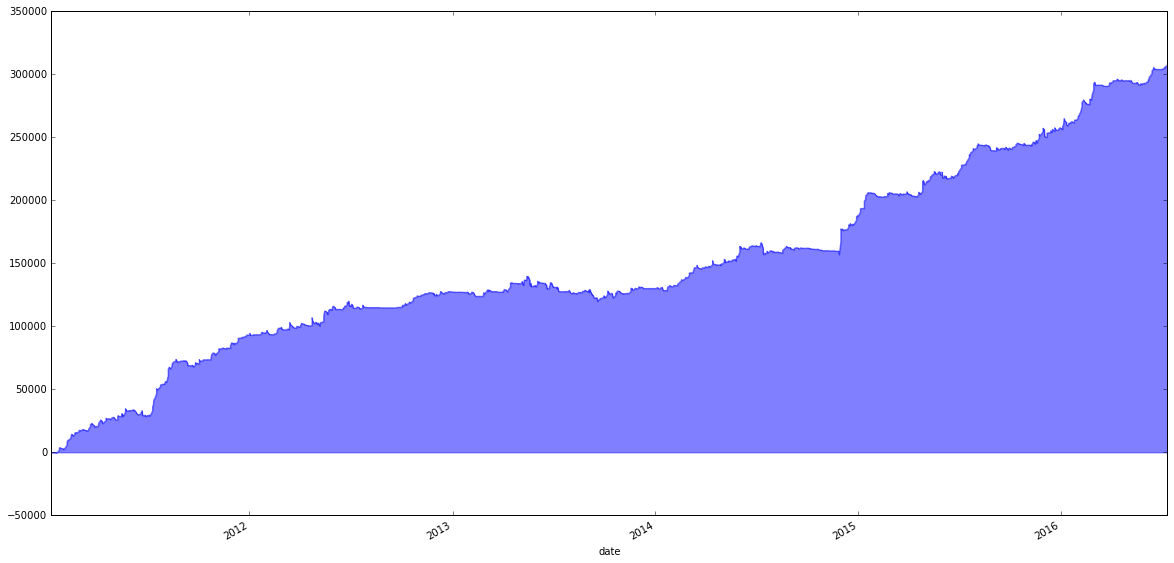

In [101]:
portfolio_stats(best_portfolio, 'Best')

Portfolio name --- Worst(reversed)


PriceChange Mod. Sharpe -0.0303286516481296
Netprofit -22854.0
Max DD -40320.0
Recovery Factor -0.56681547619
Profit factor 0.881413449564
Winrate 36.1714621257


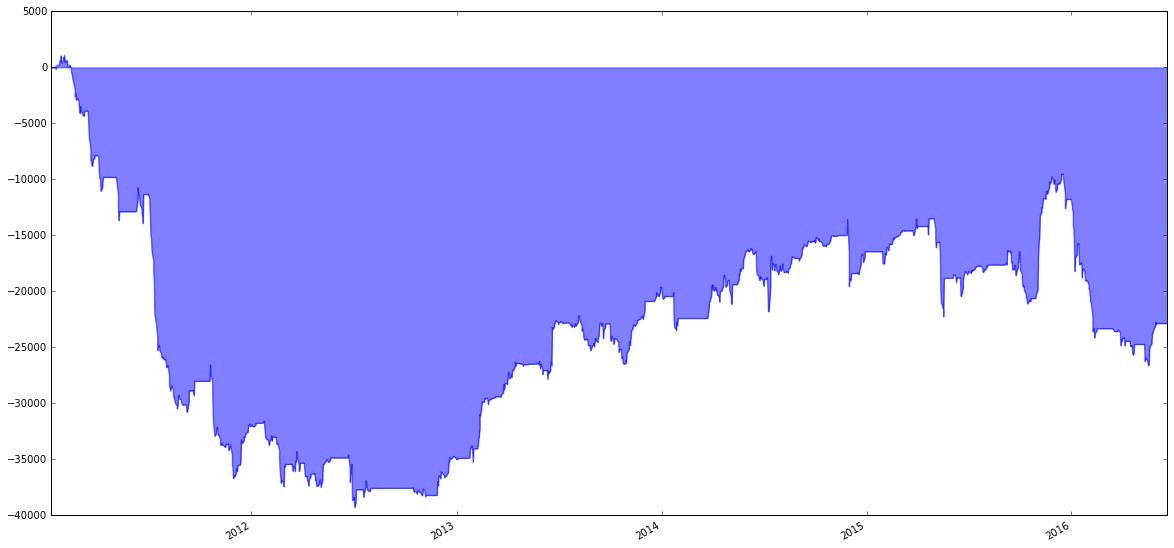

In [24]:
portfolio_stats(worst_portfolio, 'Worst(reversed)')

In [25]:
portfolio_stats(summary_portfolio, 'Summary(Best + Worst)')

ZeroDivisionError: float division by zero

Portfolio name --- Benchmark(Trade all strategies)


PriceChange Mod. Sharpe 0.0303286516481296
Netprofit 22854.0
Max DD -29752.0
Recovery Factor 0.768150040333
Profit factor 1.13454134435
Winrate 28.7727539636


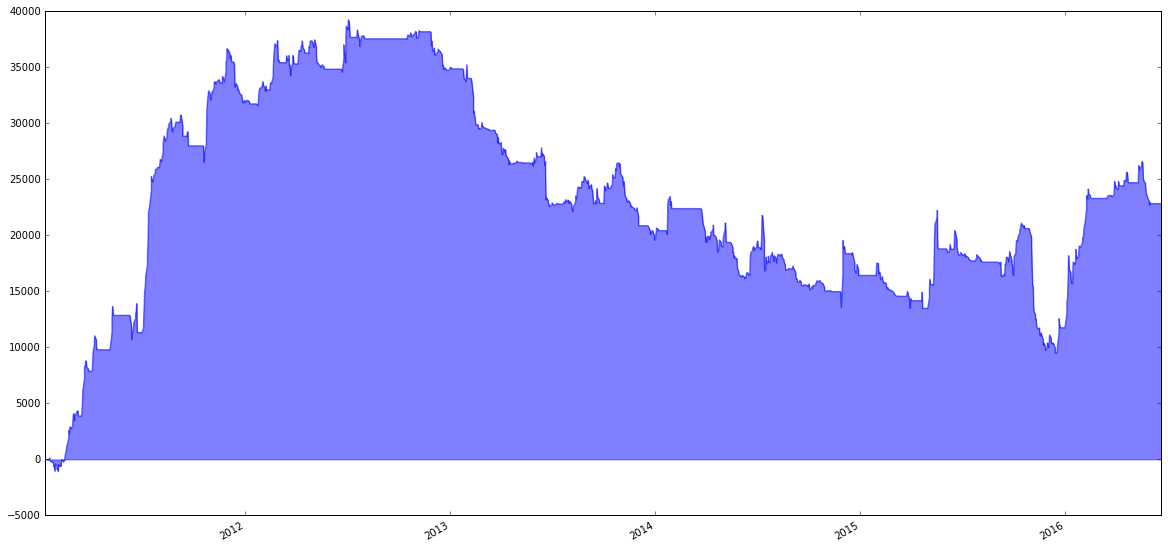

In [26]:
portfolio_stats(benchmark_portfolio, 'Benchmark(Trade all strategies)')

Portfolio name --- Picked swarm with current approach


PriceChange Mod. Sharpe -0.01381900355050882
Netprofit -7974.0
Max DD -34632.0
Recovery Factor -0.230249480249
Profit factor 0.911415748311
Winrate 9.63014654571


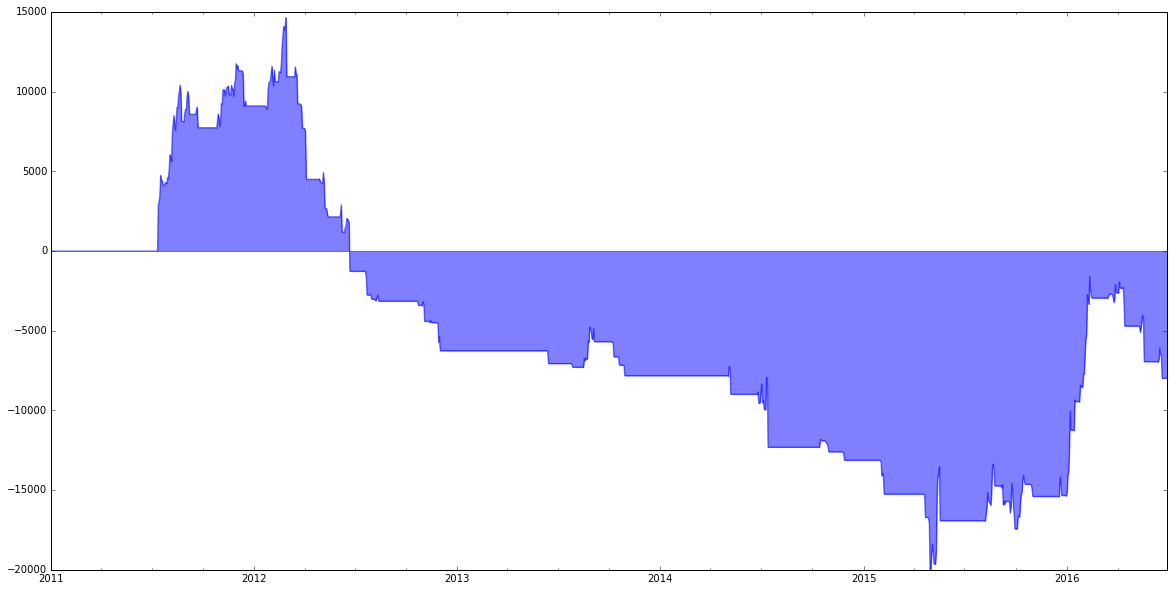

In [27]:
portfolio_stats(swarm.swarm_picked.sum(axis=1), 'Picked swarm with current approach')

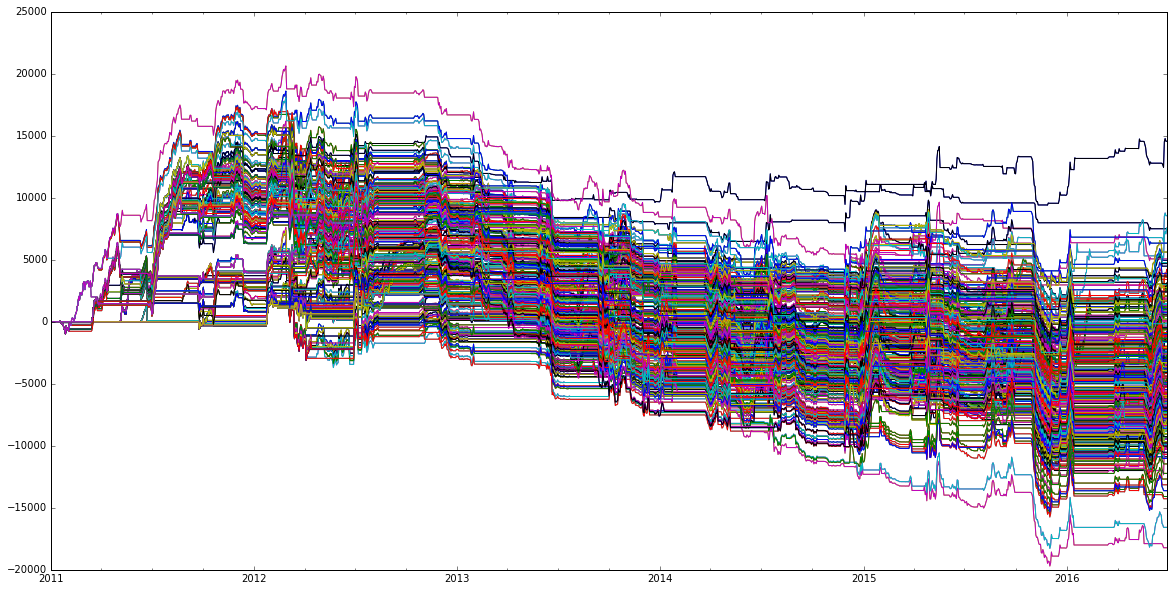

In [250]:
swarm.swarm.plot(legend=False)